In [52]:
import pandas as pd
import pickle
df_seoul = pd.read_pickle('seoul_신한카드.pkl')
df_dong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 행정동코드', skiprows=1)
df_upjong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 업종코드', skiprows=1)
df_upjong_code = df_upjong_code[['업종코드 (32개 분류)']]
df_upjong_code.dropna(inplace=True)

In [53]:
df_seoul

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,건별 이용금액
구코드,,,,,,,,
140,20190201,520,10,F,20,14,1038,74.1
140,20190201,520,10,F,25,59,4635,78.6
140,20190201,520,10,F,30,41,3046,74.3
140,20190201,520,10,F,35,59,5995,101.6
140,20190201,520,10,F,40,45,5172,114.9
...,...,...,...,...,...,...,...,...
350,20200531,720,81,M,45,19,127,6.7
350,20200531,720,81,M,50,33,211,6.4
350,20200531,720,81,M,55,9,61,6.8


In [54]:
#20대만보기위해 필터링
df_seoul = df_seoul.query('나이코드 in [20,25]')
df_seoul = df_seoul.query('Year==2020 or (Year==2019 and 이용건수>100)')
df_seoul

UndefinedVariableError: name 'Year' is not defined

In [55]:
pd.options.display.float_format = '{:.1f}'.format

In [56]:
df_dong_code = df_dong_code[:34]

In [57]:
import re
upjong_dic={}
gu_dic={}
gu_dong_dic={}
for i, j in zip(df_dong_code['구코드'], df_dong_code['구명']):
    gu_dic[i]=j
for i, j, x, y in zip(df_dong_code['구코드'], df_dong_code['구명'], df_dong_code['행정동코드'], df_dong_code['행정동명']):
    gu_dong_dic[(i,x)]=y
for i in df_upjong_code.values:
    key = re.findall('\((.*)\)',i[0])[0]
    val = re.findall('(.*)\(',i[0])[0]
    upjong_dic[key]=val

In [25]:
#type 바꿔주기
df_seoul['기준일자'] = df_seoul['기준일자'].astype(str)
df_seoul['기준일자'] = pd.to_datetime(df_seoul['기준일자'])
df_seoul['업종코드'] = df_seoul['업종코드'].astype(str)

#시구, 동, 업종코드 mapping
df_seoul['시_구'] = df_seoul.index.map(gu_dic)
df_seoul['행정동'] = [gu_dong_dic[(i,x)] for i,x in zip(df_seoul.index, df_seoul['행정동코드'])]
df_seoul['업종'] = df_seoul['업종코드'].map(upjong_dic)

In [26]:
df_seoul['Year'] = df_seoul['기준일자'].dt.year
df_seoul['Month'] = df_seoul['기준일자'].dt.month

구별 (업종별, 성별, 나이별, (이용금액,건수))
140:중구, 350:노원구

In [27]:
df_seoul['행정동코드'].unique()

array([520, 540, 550, 570, 580, 590, 605, 615, 625, 635, 645, 650, 665,
       670, 680, 560, 595, 600, 611, 612, 619, 621, 624, 630, 640, 695,
       700, 710, 720], dtype=int64)

In [28]:
df_set={}

In [29]:
df_0 = df_seoul[['시_구','업종','Year','이용건수','이용금액']].groupby(['시_구','업종','Year']).mean()

In [30]:
df_1 = df_seoul.query('업종 not in ["의료기관", "보건위생", "자동차정비"]')

df_1 = df_1[['시_구','행정동','업종','Year','Month','이용건수','이용금액']].groupby(['시_구','행정동','Month','업종','Year']).mean()
test = df_1.reset_index().set_index(['시_구','행정동','Month','업종'])
#2019가 없는 항목은 제외시키기
for i in test.index:
    if len(test.loc[i])!=2:
        test.drop(i,inplace=True)
df_1 = test.reset_index().set_index(['시_구','행정동','Month','업종','Year'])


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
def gu_dong(gu, dong):
    for m in df_seoul.Month.unique():
        if m == 2:
            df_2 = df_1.loc[gu,dong,m].T  
            ##여기에다가 이용건수에대한 threshold 주면좋을듯 
            
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new = pd.DataFrame(a)
            df_new.columns = ['2월']
        
        else : 
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new['{}월'.format(m)] = a
    print(gu, dong)        
    print(df_1.loc[gu,dong])
    df_new = df_new.stack().reset_index()
    df_new.columns = ['업종','월','전년대비_변화율']
    sns.barplot(data = df_new, x = '업종', y = '전년대비_변화율', hue='월')
    plt.ylim(-100, 100)
    plt.grid(which='major', axis='y') 
    plt.title(dong, {'fontsize' : 25, 'color':'black'})
    

In [32]:
print(len(df_seoul[df_seoul['시_구']=='서울 중구']['행정동'].unique()))
print(len(df_seoul[df_seoul['시_구']=='서울 노원구']['행정동'].unique()))

15
19


In [33]:
def makefigure(gu):
    Fig=plt.figure(figsize=(20,50))
    for i,dong in enumerate(df_seoul[df_seoul['시_구']==gu]['행정동'].unique()):
        Fig.add_subplot(ceil(len(df_seoul[df_seoul['시_구']==gu]['행정동'].unique())/2),2,i+1) 
        gu_dong(gu, dong)
    Fig.tight_layout()
    Fig.show()
    figure_dir = './img'
    import os
    if os.path.isdir(figure_dir) == False:
        os.mkdir(figure_dir)
    Fig.savefig(figure_dir+'/{}전년대비이용금액.png'.format(gu))
    Fig.show()

서울 중구 소공동
                 이용건수   이용금액
Month 업종   Year             
2     광학제품 2019   6.0  193.0
           2020   5.4   66.2
      레저업소 2019  10.1  929.3
           2020  11.0 1117.3
      레저용품 2019   5.4  270.2
...               ...    ...
5     음료식품 2020  72.3  548.4
      의복   2019  11.2  550.8
           2020   7.6  366.7
      주방용구 2019   4.0  203.0
           2020   5.0  477.0

[122 rows x 2 columns]
서울 중구 회현동
                 이용건수   이용금액
Month 업종   Year             
2     가전   2019  10.4 1980.4
           2020   6.8 1301.4
      광학제품 2019   6.1  395.0
           2020   5.1  152.7
      레저업소 2019  10.4   90.0
...               ...    ...
5     의복   2020  12.4  747.0
      주방용구 2019   5.3  771.4
           2020   8.9  782.2
      직물   2019   7.7  263.5
           2020   6.9  240.0

[136 rows x 2 columns]
서울 중구 명동
                 이용건수   이용금액
Month 업종   Year             
2     가전   2019   8.5  918.1
           2020   7.4 1008.9
      광학제품 2019   7.8  697.7
           2020   5.3  7

<ipython-input-33-d466a8d4960a>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()
<ipython-input-33-d466a8d4960a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()


서울 노원구 월계1동
                 이용건수   이용금액
Month 업종   Year             
2     광학제품 2019   5.0  103.5
           2020   4.0   59.6
      레저업소 2019 294.5 1813.1
           2020 277.6 1793.7
      레저용품 2019   6.1  744.0
...               ...    ...
5     음료식품 2020  38.5  291.8
      의복   2019   5.9  187.4
           2020   5.0  720.2
      직물   2019   9.0  367.0
           2020   5.0  122.0

[114 rows x 2 columns]
서울 노원구 월계2동
                 이용건수   이용금액
Month 업종   Year             
2     레저업소 2019   5.5 1047.1
           2020   5.1   55.1
      문화취미 2019   6.3  129.5
           2020   4.0  120.5
      서적문구 2019   6.0   32.6
...               ...    ...
5     유통업  2020 191.2 1023.0
      음료식품 2019  15.6  102.7
           2020  12.7  135.5
      의복   2019   6.5  185.5
           2020   5.0   51.3

[80 rows x 2 columns]
서울 노원구 월계3동
                 이용건수   이용금액
Month 업종   Year             
2     광학제품 2019   5.4   73.3
           2020   4.6   93.2
      레저업소 2019  22.1  166.4
           2020  3

<ipython-input-33-d466a8d4960a>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()
<ipython-input-33-d466a8d4960a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()


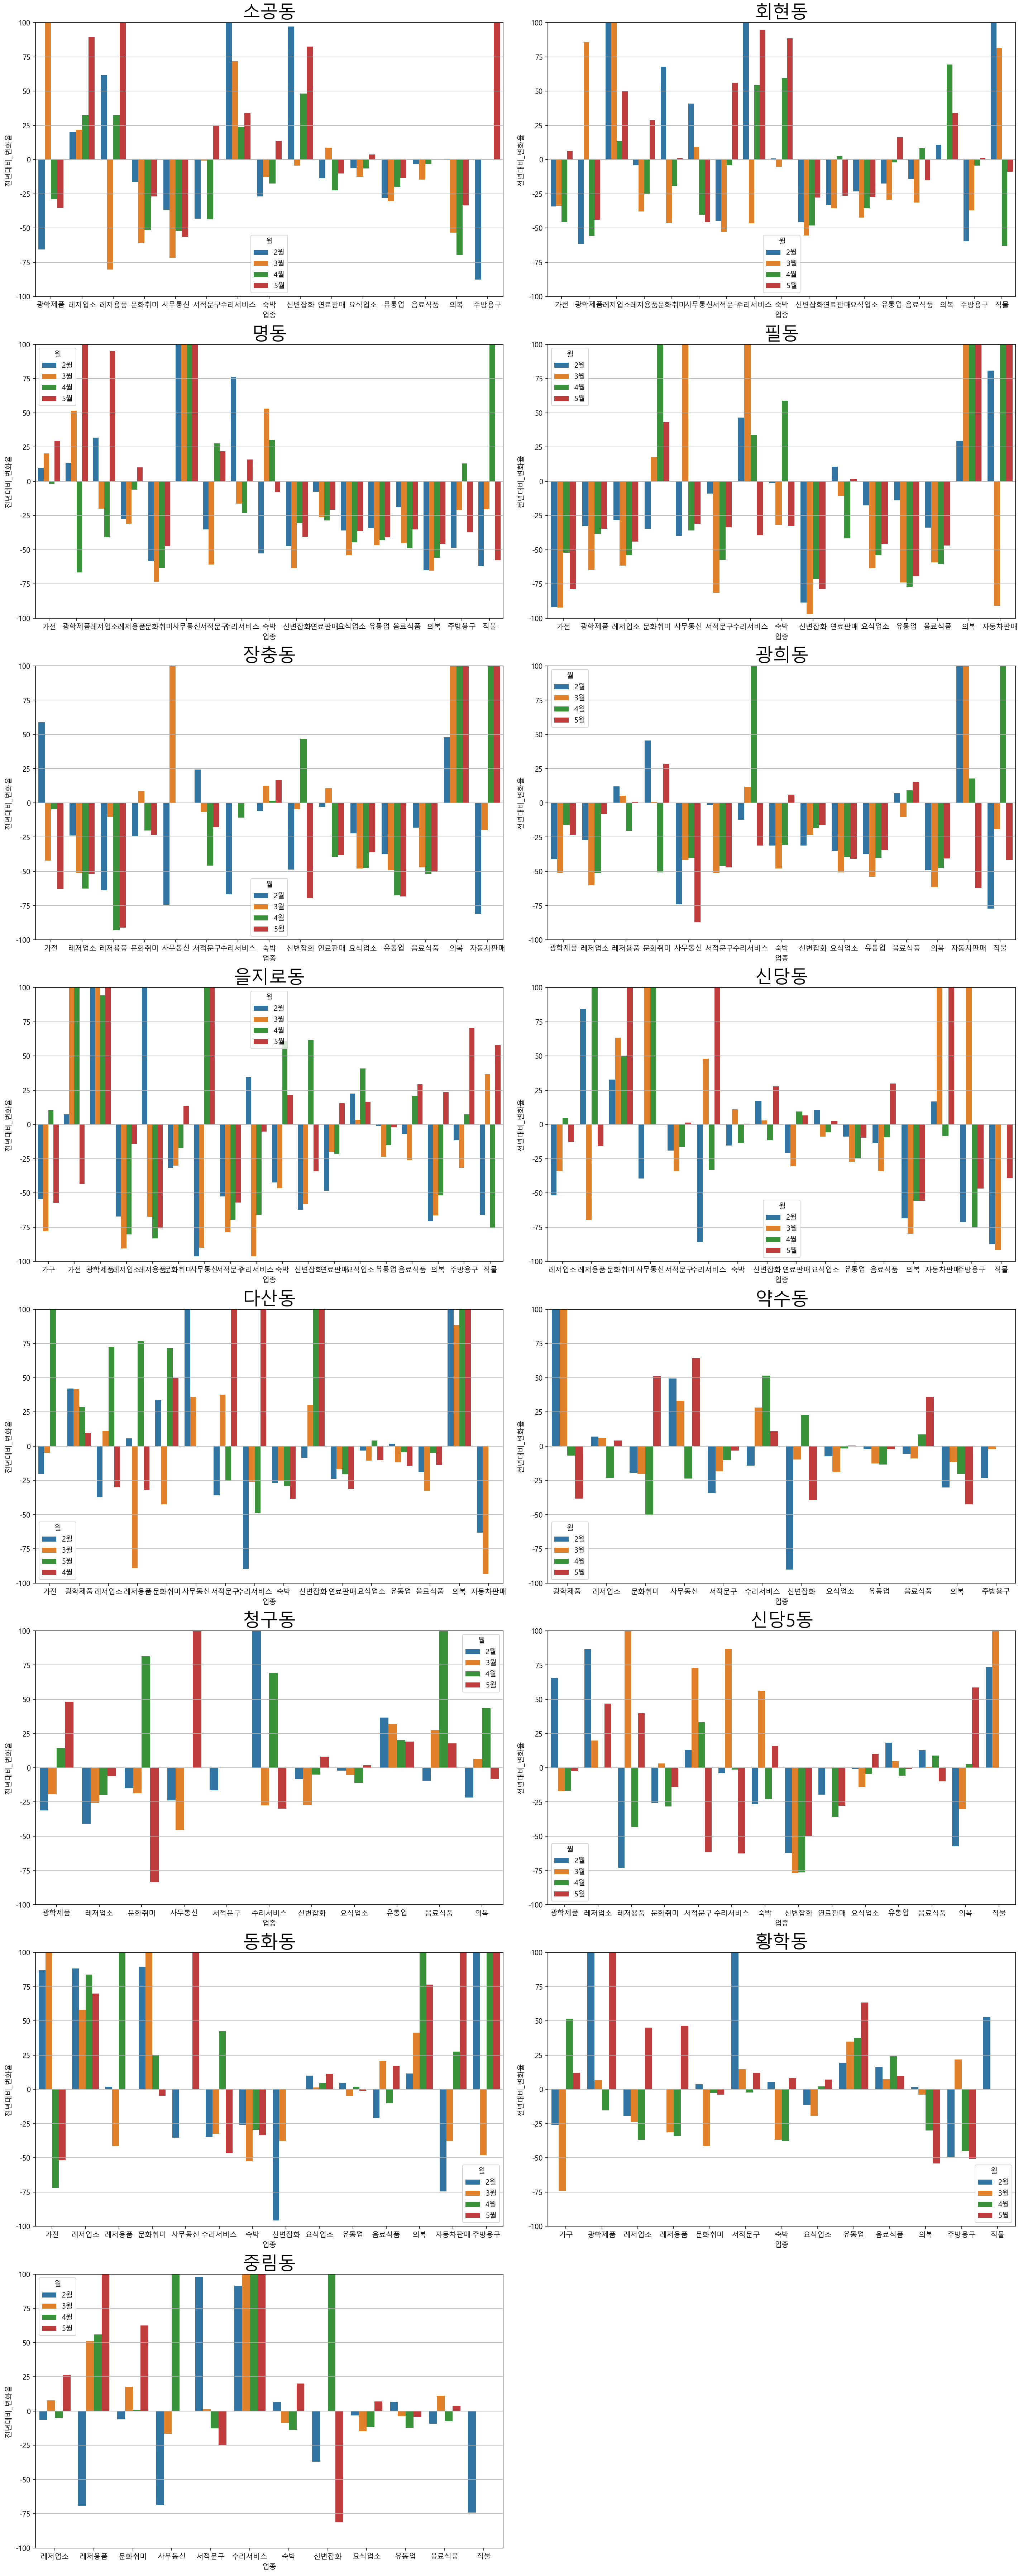

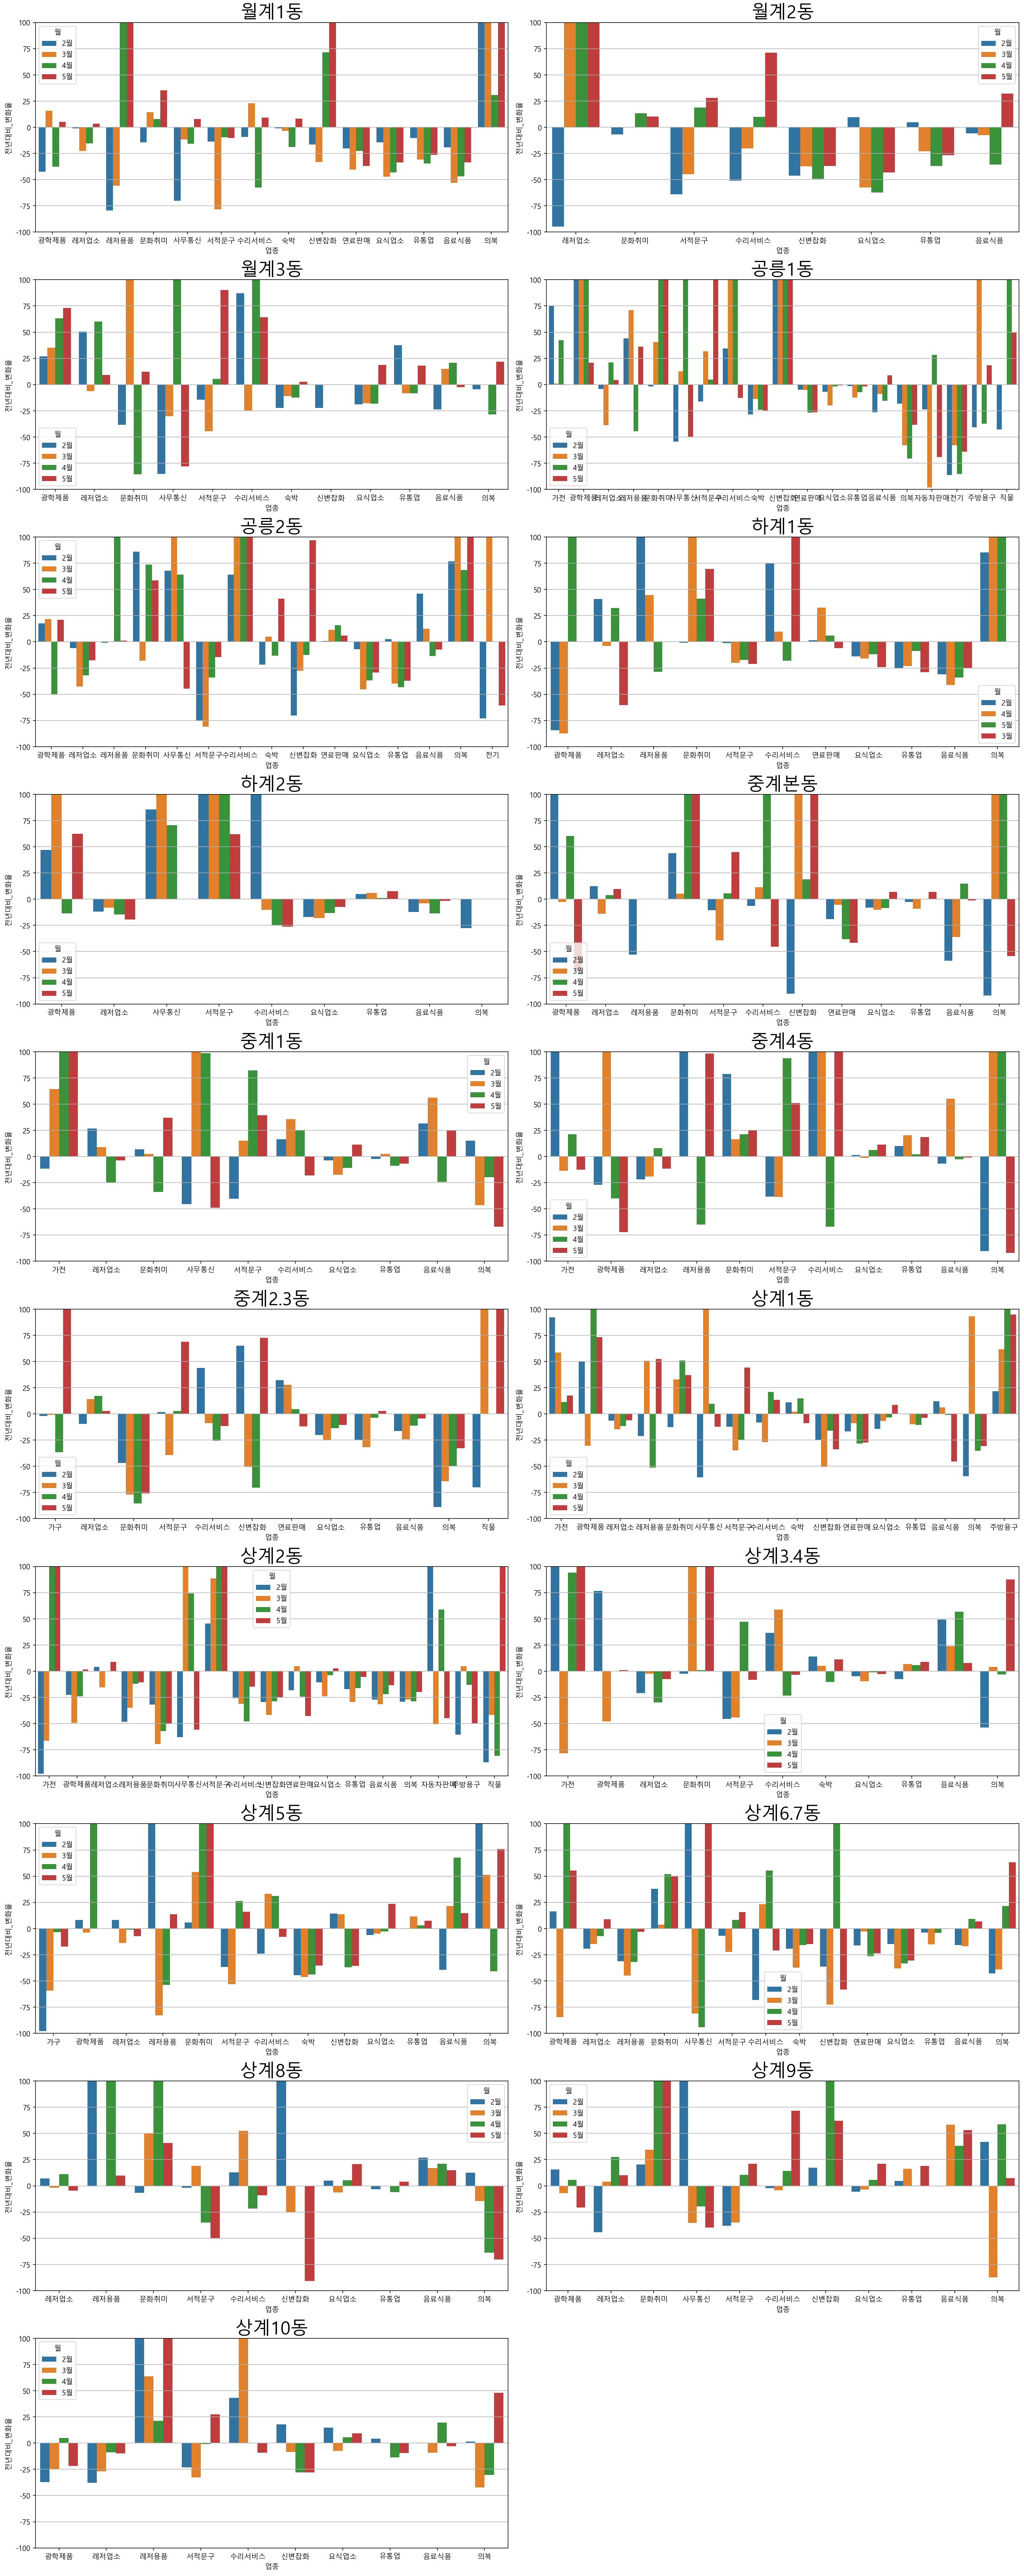

In [34]:
from math import ceil

for gu in ['서울 중구','서울 노원구']:
    makefigure(gu)
    
#신한카드가 가계의 매출전체를 대변할 수는 없지만 경향성을 설명해줄수 있다

서울 노원구 공릉1동
                 이용건수   이용금액
Month 업종   Year             
2     가전   2019   6.9  779.8
           2020   4.2 1366.8
      광학제품 2019   5.0  157.7
           2020   4.6  596.2
      레저업소 2019 110.4 1332.6
...               ...    ...
5     전기   2020   5.0  137.0
      주방용구 2019   4.7   33.1
           2020   5.6   39.1
      직물   2019   8.0  279.9
           2020   6.0  418.8

[156 rows x 2 columns]


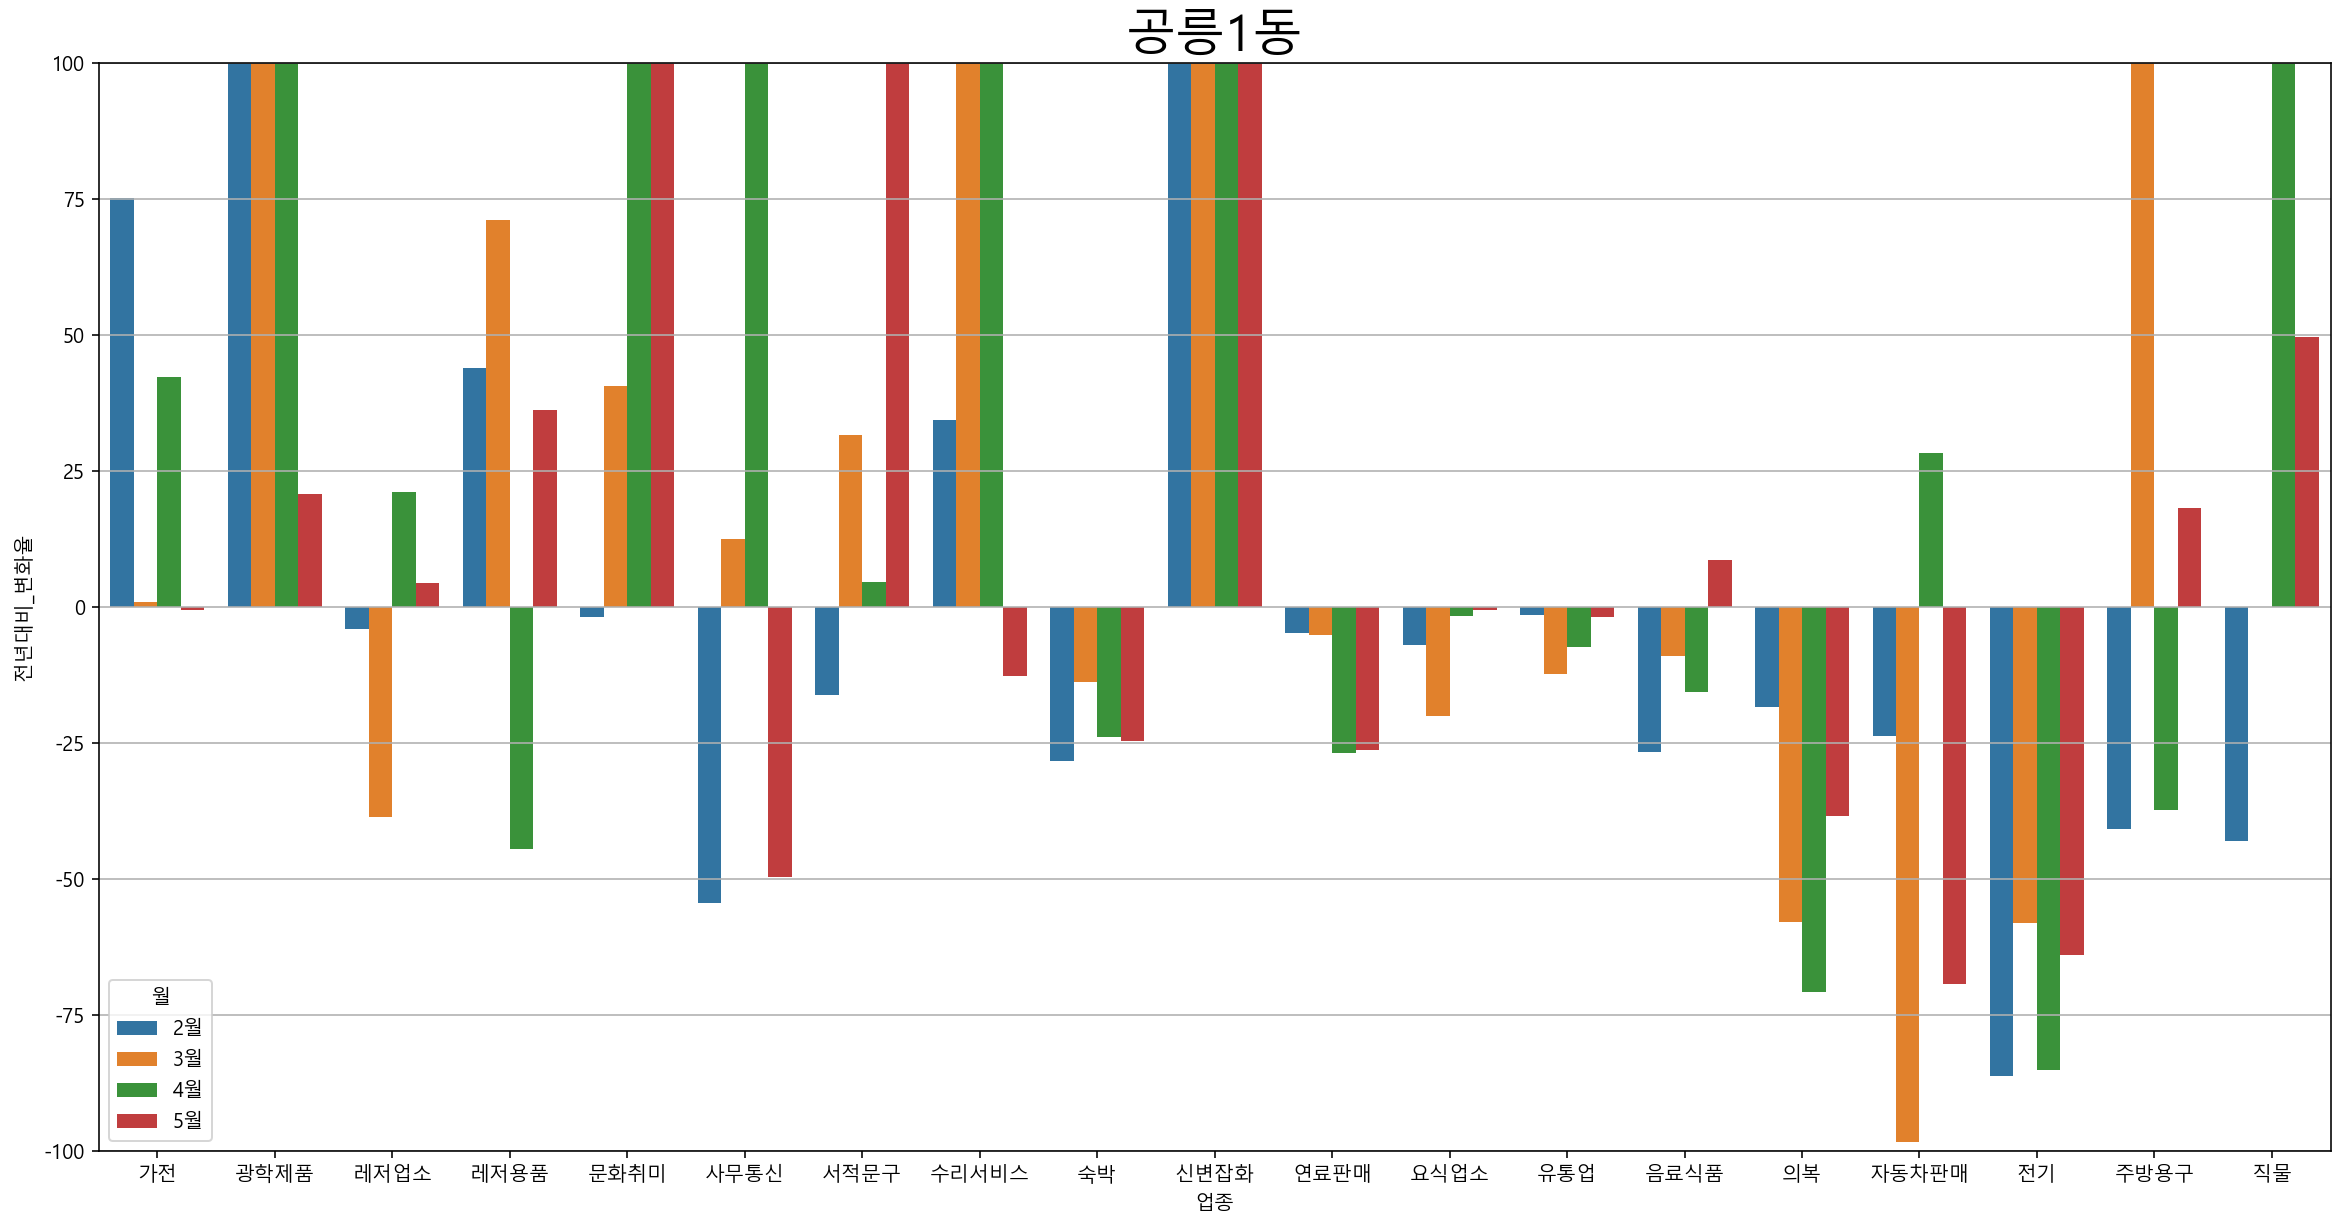

In [35]:
plt.rcParams['figure.figsize'] = [20,10]
gu_dong('서울 노원구','공릉1동')

In [36]:
df_new

NameError: name 'df_new' is not defined

# 노원구 중구의 코로나 이전(2019)과 이후(2020) 업종별 이용건수 이용금액 추이

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

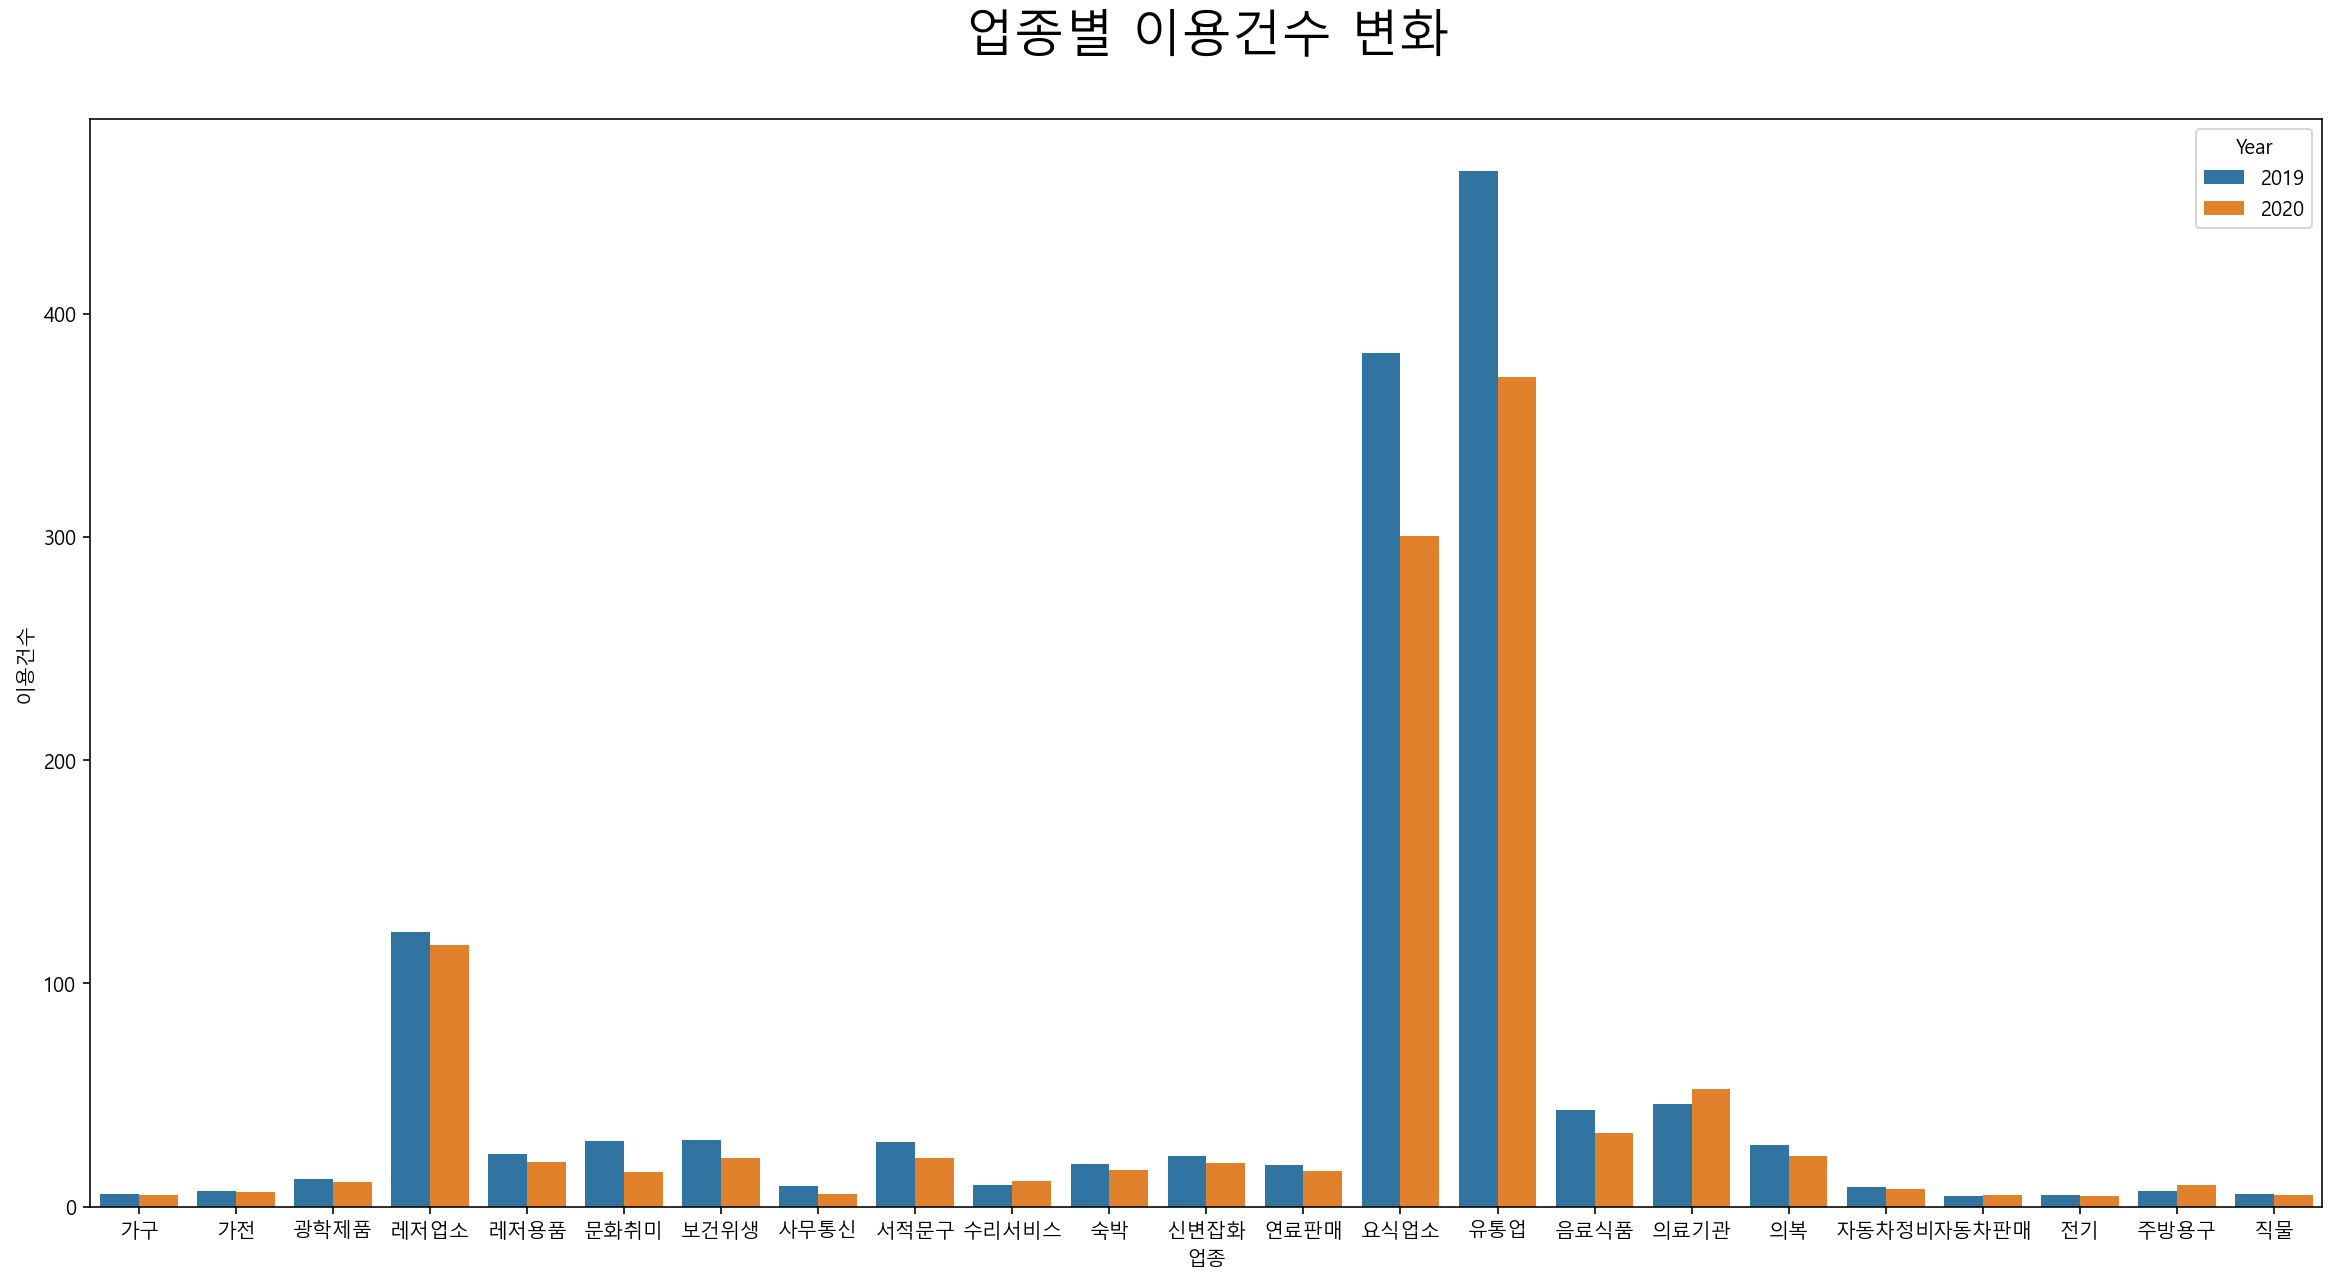

In [37]:

plt.rcParams['figure.figsize'] = [20,10]
g1 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용건수',hue='Year', ci=None)
plt.title('업종별 이용건수 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

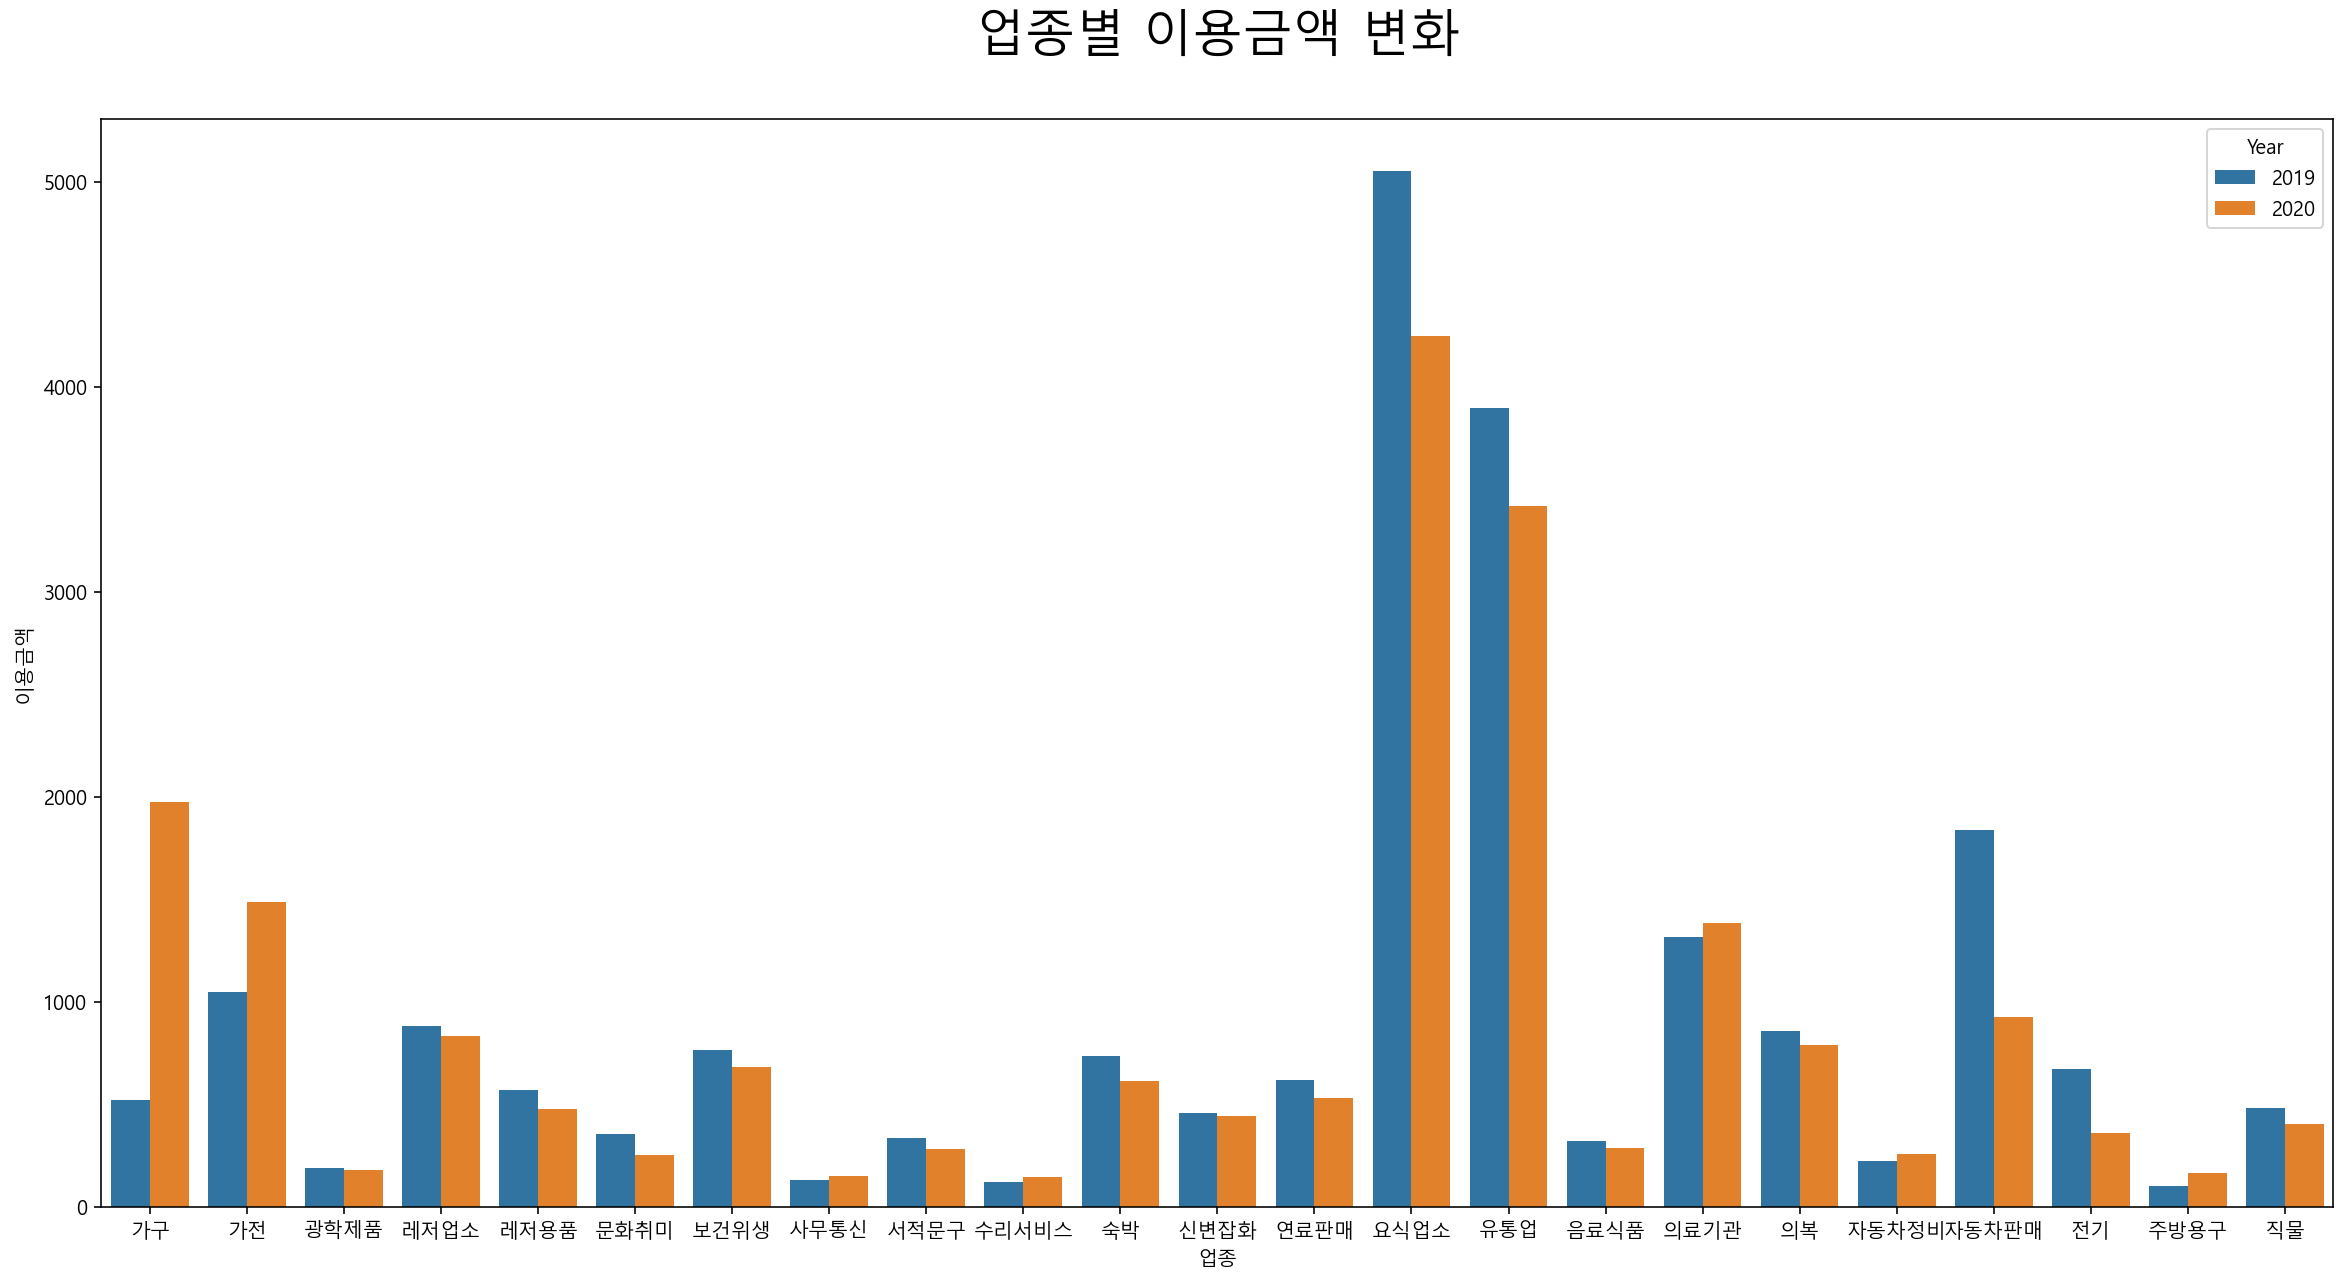

In [38]:
g2 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)
plt.title('업종별 이용금액 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

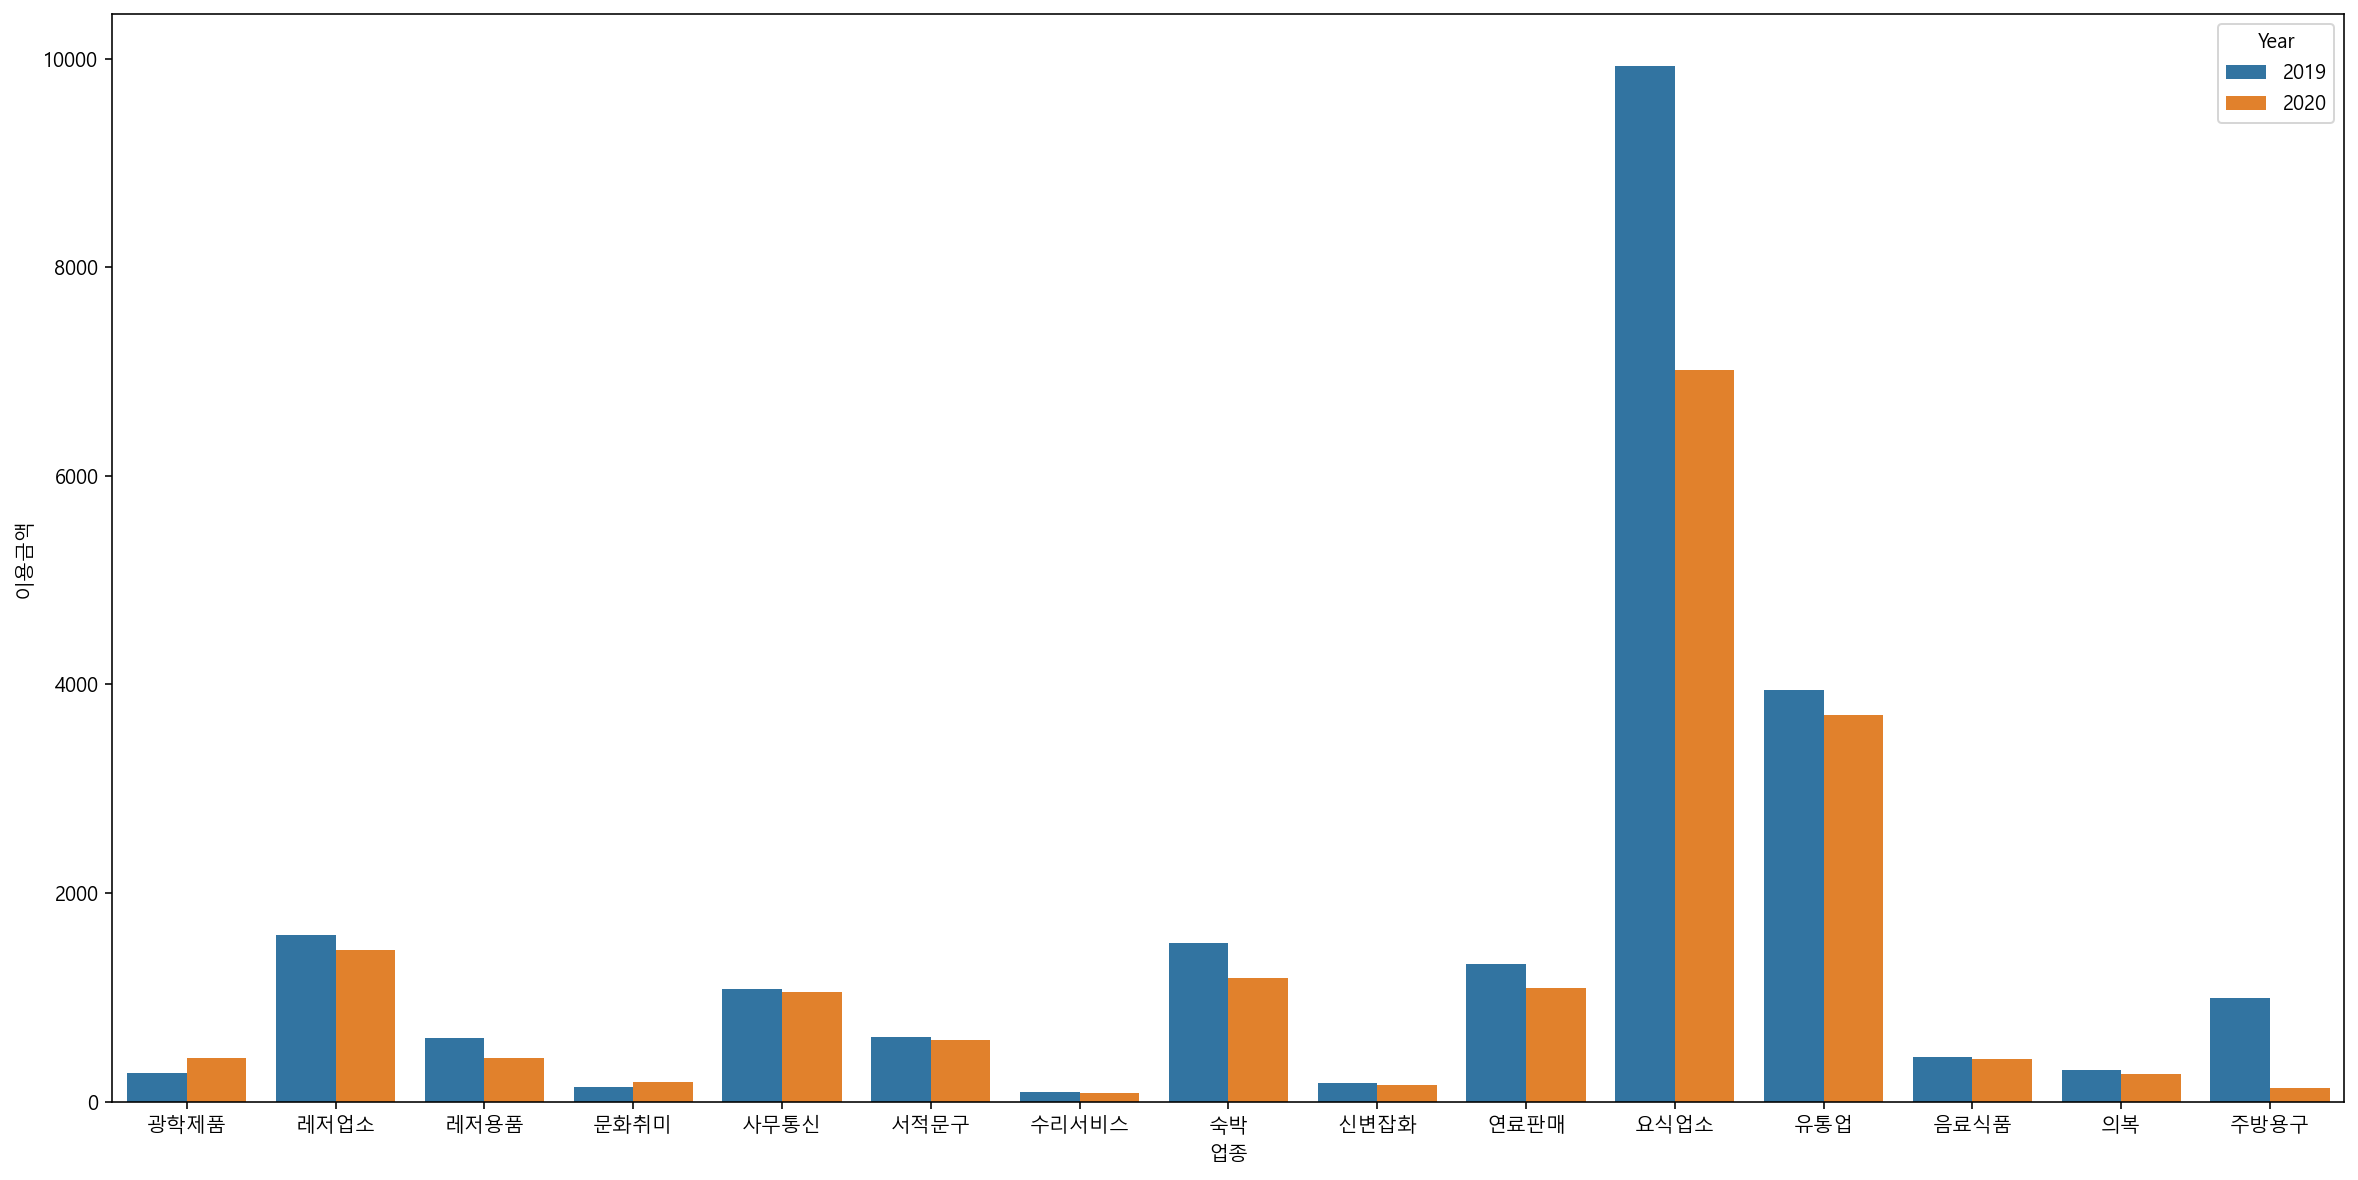

In [41]:
g3 = sns.barplot(data = df_1.loc['서울 노원구','상계6.7동'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [42]:
g3 = sns.barplot(data = df_0.loc['서울 중구',5].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [5] of <class 'int'>

In [43]:
df_set['동별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['행정동','기준일자'],as_index=True).sum()[['이용건수','이용금액']]
df_set['업종별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['업종','기준일자'],as_index=True).sum()[['이용건수','이용금액']]

---

In [44]:
import pandas as pd
import pickle
df_corona = pd.read_csv('modeling/data/서울시 확진자 현황.csv', encoding='ANSI')

In [45]:
df_corona.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,3867,8.30.,19855,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
1,3866,8.30.,19897,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
2,3865,8.30.,19900,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
3,3864,8.30.,19788,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
4,3863,8.30.,19797,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y


In [46]:
df_corona['접촉력'].value_counts()[:30].to_csv('abcd.csv', encoding='cp949')

In [47]:
dfhan = pd.read_pickle('modeling/data/검색어트렌드_한양대_final.pkl')

In [48]:
dfhan

,date,한양대역,가락시장역,가산디지털단지역,강남역,강남구청역,강동역,강동구청역,강변역,개롱역,...,학여울역,한강진역,한성대입구역,합정역,행당역,혜화역,홍대입구역,홍제역,화곡역,화랑대역
0,2020-02-01,18.2,14.3,28.1,175.4,23.1,46.1,32.1,39.7,2.4,...,1.1,22.2,4.1,245.8,1.2,123.2,10.6,4.9,39.3,4.8
1,2020-02-02,18.4,13.7,27.6,180.0,22.7,48.5,31.2,39.7,2.4,...,1.1,24.1,4.2,250.4,1.2,128.5,11.1,4.9,39.3,5.3
2,2020-02-03,18.1,13.5,27.6,184.3,22.5,49.9,31.3,39.8,2.4,...,1.1,24.3,3.9,250.3,1.2,128.1,10.7,4.8,39.8,5.6
3,2020-02-04,18.4,13.2,28.3,188.3,22.8,48.4,31.8,38.2,2.3,...,1.2,23.5,3.8,245.5,1.1,125.5,10.6,4.8,37.7,5.6
4,2020-02-05,19.0,13.0,28.4,191.7,22.6,48.2,31.2,38.3,2.3,...,1.2,23.9,3.7,245.1,1.1,125.7,10.7,4.5,37.3,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2020-08-27,10.8,16.5,24.5,134.3,20.5,65.3,35.5,35.4,2.9,...,0.0,15.3,3.8,194.9,1.2,73.8,6.6,7.7,40.4,7.4
209,2020-08-28,10.1,17.3,24.8,141.1,21.0,70.2,36.9,37.6,2.3,...,0.0,16.0,4.1,208.4,1.2,79.1,6.8,8.2,43.1,8.8
210,2020-08-29,9.3,18.0,24.9,149.5,20.9,77.1,38.3,41.7,2.6,...,0.0,16.9,4.1,225.3,1.3,85.2,7.3,9.1,47.7,9.3
211,2020-08-30,8.4,18.5,23.2,155.0,19.8,86.7,40.2,44.0,2.0,...,0.0,17.3,4.0,231.0,1.1,86.8,7.7,9.9,51.6,11.2


서울시 확진자 중 감염경로라고 볼수 있는 접촉력에대해 보면 밀집된 장소에서 주로 감염이 되었다고 볼수있다.
-> 밀집된장소는 위험하다, 피해야한다